In [1]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 9)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [75]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=50, cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

## Cross-Validation

Data: Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2012-2018.

In [3]:
tr = pd.read_csv('traffic_one_hot.csv')
df_interact(tr)

interactive(children=(IntSlider(value=0, description='row', max=48194, step=7), IntSlider(value=0, description…

(48194 rows, 28 columns) total


You should implement K-fold CV yourself to really understand it. For now, we'll use sklearn.

In [45]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(
    tr.iloc[:, 1:], tr.iloc[:, 0], test_size=0.1
)

In [46]:
X = X.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y = y.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X

,temp,rain_1h,snow_1h,clouds_all,...,hr=20,hr=21,hr=22,hr=23
0,274.70,0.25,0.0,64,...,0,0,0,0
1,297.69,0.00,0.0,75,...,0,0,0,0
2,307.69,0.00,0.0,1,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
43371,297.83,0.00,0.0,1,...,0,0,0,0
43372,263.82,0.00,0.0,64,...,0,0,0,0
43373,273.02,0.00,0.0,40,...,0,0,0,1


In [47]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
for train_ind, valid_ind in kf.split(X):
    X_train, X_valid = X.iloc[train_ind], X.iloc[valid_ind]
    y_train, y_valid = y.iloc[train_ind], y.iloc[valid_ind]
    display(X_train.iloc[::12000])

,temp,rain_1h,snow_1h,clouds_all,...,hr=20,hr=21,hr=22,hr=23
14458,266.62,0.0,0.0,64,...,0,0,0,0
26458,277.06,0.0,0.0,90,...,0,0,0,0
38458,280.72,0.0,0.0,90,...,0,0,0,0


,temp,rain_1h,snow_1h,clouds_all,...,hr=20,hr=21,hr=22,hr=23
0,274.70,0.25,0.0,64,...,0,0,0,0
12000,264.03,0.00,0.0,1,...,0,0,0,0
38458,280.72,0.00,0.0,90,...,0,0,0,0


,temp,rain_1h,snow_1h,clouds_all,...,hr=20,hr=21,hr=22,hr=23
0,274.70,0.25,0.0,64,...,0,0,0,0
12000,264.03,0.00,0.0,1,...,0,0,0,0
24000,267.73,0.00,0.0,90,...,0,0,0,0


In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

def keep_cols(X, cols):
    return X[:, cols]

def poly_model(degree):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression(fit_intercept=True),
    )

def mini_model(cols):
    return make_pipeline(
        FunctionTransformer(keep_cols, kw_args=dict(cols=cols)),
        LinearRegression(fit_intercept=True),
    )

In [49]:
from sklearn.model_selection import cross_validate

model = poly_model(1)
scores = cross_validate(model, X, y, scoring='neg_mean_squared_error', cv=5)
valid_error = -scores['test_score'].mean()
valid_error

5741701.697350254

In [50]:
def cv(model):
    return cross_validate(model, X, y, scoring='neg_mean_squared_error',
                          return_train_score=True, cv=5)

In [51]:
def val_error(cv):
    return -cv['test_score'].mean()

In [52]:
models = pd.DataFrame({
    'name': ['mini[0]', 'mini[0-2]', 'mini[4-27]', 'lin', 'poly2'],
    'model': [
        mini_model([0]), mini_model([0, 1, 2]), mini_model(np.arange(4, 27)),
        poly_model(1), poly_model(2),
    ],
})

In [53]:
models['cv'] = models['model'].apply(cv)
models['val_error'] = models['cv'].apply(val_error)
models

,name,model,cv,val_error
0,mini[0],"(FunctionTransformer(accept_sparse=False, chec...","{'fit_time': [0.021548986434936523, 0.01420426...",3.89e+06
1,mini[0-2],"(FunctionTransformer(accept_sparse=False, chec...","{'fit_time': [0.01587510108947754, 0.012521982...",1.33e+07
2,mini[4-27],"(FunctionTransformer(accept_sparse=False, chec...","{'fit_time': [0.036926984786987305, 0.03938102...",8.94e+05
3,lin,"(PolynomialFeatures(degree=1, include_bias=Fal...","{'fit_time': [0.05012917518615723, 0.042407989...",5.74e+06
4,poly2,"(PolynomialFeatures(degree=2, include_bias=Fal...","{'fit_time': [1.166236162185669, 0.98908615112...",4.66e+11


In [54]:
models['cv'][0]

{'fit_time': array([0.02, 0.01, 0.02, 0.01, 0.01]),
 'score_time': array([0.  , 0.  , 0.01, 0.  , 0.  ]),
 'test_score': array([-3860967.82, -3859726.38, -3870789.51, -3898130.61, -3937751.04]),
 'train_score': array([-3891341.78, -3891672.58, -3888896.85, -3882086.66, -3872158.04])}

Takes some work, but we can extract out all the errors for plotting:

In [55]:
def identity(x): return x

def get_train_errs(models):
    return models['cv'].apply(lambda cv: -cv['train_score'])

def get_valid_errs(models):
    return models['cv'].apply(lambda cv: np.log(-cv['test_score']))

def make_errors(models, errs):
    return (pd.DataFrame.from_items(zip(errs.index, errs.values))
            .melt(var_name='index', value_name='mse')
            .merge(models[['name']], left_on='index', right_index=True))

def plot_errors(errors, log=False, err_type='Training'):
    plt.figure(figsize=(8, 4))
    sns.pointplot('name', 'mse', ci='sd', data=errors)
    plt.xlabel('Model')
    plt.ylabel('log(mse)' if log else 'mse')
    plt.title(f'{err_type} Error')

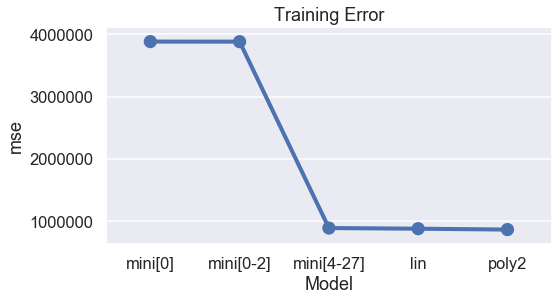

In [56]:
errors = make_errors(models, get_train_errs(models))
plot_errors(errors, log=False, err_type='Training')

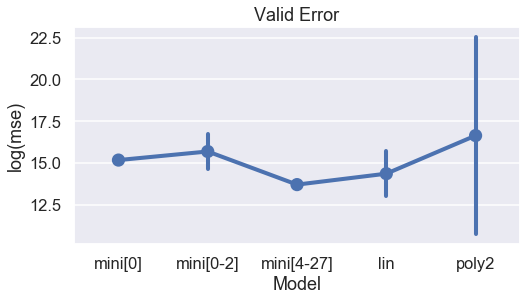

In [57]:
errors = make_errors(models, get_valid_errs(models))
plot_errors(errors, log=True, err_type='Valid')

## Regularization

In [104]:
water = pd.read_csv('water.csv')
water

,water_level_change,water_flow
0,-15.94,2.13
1,-29.15,1.17
2,36.19,34.36
...,...,...
20,7.09,8.35
21,46.28,52.78
22,14.61,13.36


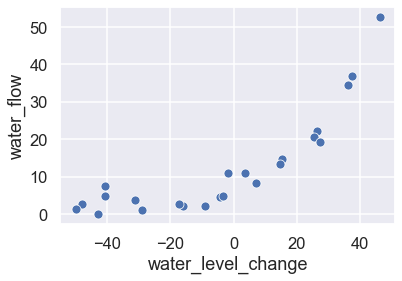

In [105]:
sns.scatterplot('water_level_change', 'water_flow', data=water)

In [106]:
X = water.iloc[:, [0]]
y = water.iloc[:, 1]

In [107]:
from sklearn.linear_model import Ridge, Lasso

def ridge_model(degree, alpha=1.0):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        Ridge(alpha=alpha, normalize=True),
    )

def lasso_model(degree, alpha=1.0):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        Lasso(alpha=alpha, normalize=True, precompute=True, tol=0.005),
    )

In [110]:
from itertools import chain

def plot_model(model, ax=None):
    if not ax: ax = plt.gca()
    model.fit(X, y)
    xs = np.linspace(-50, 50, 100)
    ys = model.predict(xs.reshape((-1, 1)))
    sns.scatterplot('water_level_change', 'water_flow', data=water, ax=ax)
    sns.lineplot(xs, ys, ax=ax, color=sns.xkcd_rgb['dark gold'])
    ax.set_ylim(-5, 55)
    
def plot_models(models, cols=2):
    rows = int(np.ceil(len(models) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows),
                             sharex=True, sharey=True, squeeze=False)
    for ax, model in zip(chain(*axes), models):
        plot_model(model, ax)
    plt.tight_layout()

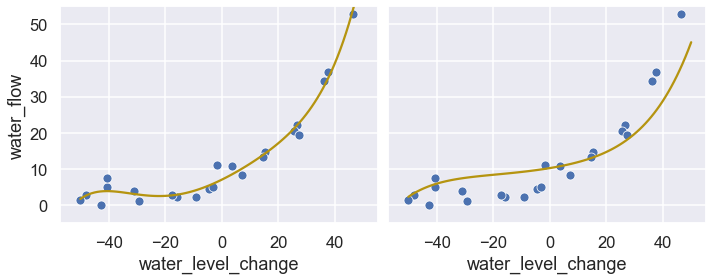

In [111]:
degree = 5

plot_models([
    poly_model(degree),
    ridge_model(degree),
])

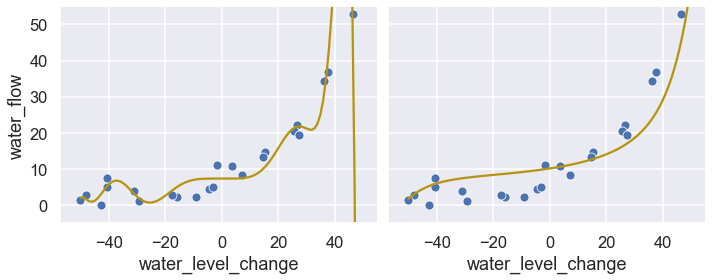

In [112]:
degree = 12

plot_models([
    poly_model(degree),
    ridge_model(degree),
])

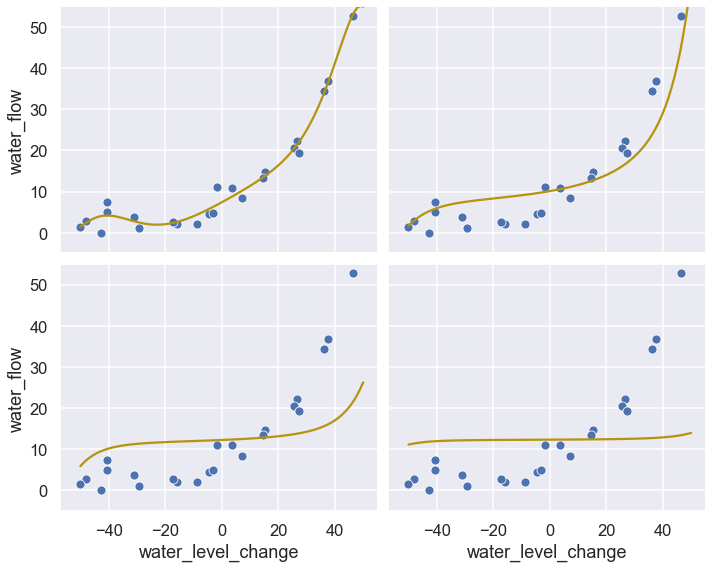

In [113]:
degree = 12

plot_models([
    ridge_model(degree, alpha=0.001),
    ridge_model(degree, alpha=1.0),
    ridge_model(degree, alpha=10),
    ridge_model(degree, alpha=100),
])

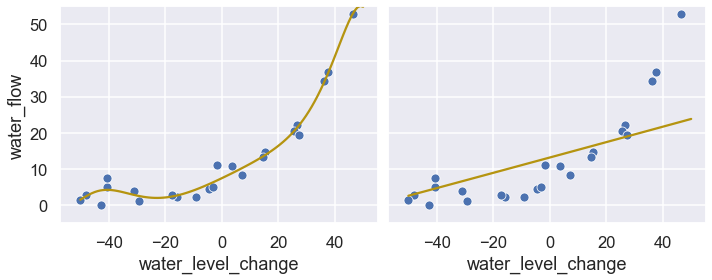

In [115]:
degree = 12

plot_models([
    ridge_model(degree, alpha=0.001),
    lasso_model(degree, alpha=1.0),
])

In [123]:
def coefs(model, name='coef'):
    clf = model.steps[-1][1]
    df = pd.DataFrame({
        name: (clf.intercept_, *clf.coef_),
    })
    df.index.name = 'deg'
    return df

def log_coefs(coefs):
    return coefs.apply(np.abs).apply(np.log10)

def plot_coefs(coefs):
    log_coefs(coefs).plot.line()

In [124]:
degree = 12
display_df(coefs(poly_model(degree).fit(X, y), name='poly')
 .join(coefs(ridge_model(degree).fit(X, y), name='ridge'))
 .join(coefs(lasso_model(degree).fit(X, y), name='lasso'))
)

,poly,ridge,lasso
deg,,,
0,7.32e+00,1.01e+01,1.31e+01
1,6.51e-11,1.20e-01,2.13e-01
2,1.70e-08,2.31e-03,1.77e-05
3,2.12e-08,4.93e-05,0.00e+00
4,3.08e-08,7.32e-07,0.00e+00
5,5.32e-06,1.75e-08,0.00e+00
6,7.62e-08,2.32e-10,0.00e+00
7,-1.09e-08,6.04e-12,0.00e+00
8,-1.62e-10,7.53e-14,0.00e+00


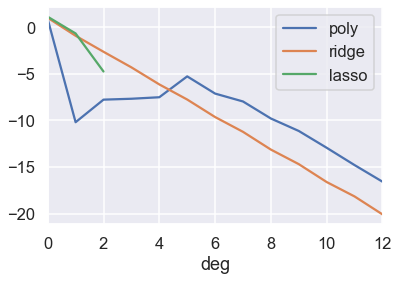

In [125]:
degree = 12
plot_coefs(coefs(poly_model(degree).fit(X, y), name='poly')
 .join(coefs(ridge_model(degree).fit(X, y), name='ridge'))
 .join(coefs(lasso_model(degree).fit(X, y), name='lasso'))
)

In [126]:
degree = 12
alpha = 0.001

display_df(coefs(poly_model(degree).fit(X, y), name='poly')
 .join(coefs(ridge_model(degree, alpha=alpha).fit(X, y), name='ridge'))
 .join(coefs(lasso_model(degree, alpha=alpha).fit(X, y), name='lasso'))
)

,poly,ridge,lasso
deg,,,
0,7.32e+00,7.41e+00,7.20e+00
1,6.51e-11,3.74e-01,3.49e-01
2,1.70e-08,2.42e-03,4.20e-03
3,2.12e-08,-6.58e-05,-1.86e-05
4,3.08e-08,5.25e-06,3.70e-06
5,5.32e-06,5.12e-08,5.44e-08
6,7.62e-08,3.02e-10,-0.00e+00
7,-1.09e-08,2.40e-11,2.86e-12
8,-1.62e-10,-3.25e-13,-4.38e-14


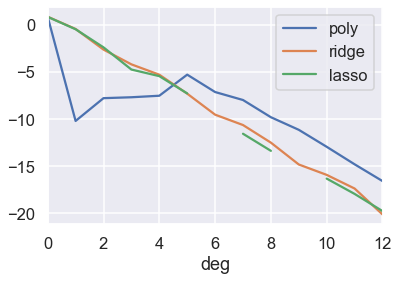

In [128]:
degree = 12
alpha = 0.001

plot_coefs(
    coefs(poly_model(degree).fit(X, y), name='poly')
    .join(coefs(ridge_model(degree, alpha=alpha).fit(X, y), name='ridge'))
    .join(coefs(lasso_model(degree, alpha=alpha).fit(X, y), name='lasso'))
)